In [1]:
%matplotlib inline
import warnings; warnings.filterwarnings(action='ignore')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

import keras
from keras import models
from keras import layers

Using TensorFlow backend.


In [2]:
df = pd.read_csv('small_strato/small_strato.dat',
                delim_whitespace=True, header=None, index_col=0)
df.columns = ['SUN', 'O1D', 'O', 'O3', 'NO', 'NO2', 'M', 'O2']
df.index.name = 'time'

df = df.apply(pd.to_numeric, errors='coerce')
df[np.isnan(df)] = 0.0

df.drop(['M', 'O2'], axis=1, inplace=True)
StandardScaler(copy=False).fit_transform(df.values);

In [3]:
df.head()

,SUN,O1D,O,O3,NO,NO2
time,,,,,,
0.00,-0.992263,0.994685,0.932928,-2.219126,0.947570,-0.947570
0.25,1.326730,1.005869,0.958368,-2.137258,1.116199,-1.116199
0.50,1.326624,1.023262,0.975577,-2.056565,1.114292,-1.114292
0.75,1.326165,1.039894,0.992132,-1.976674,1.112362,-1.112362
1.00,1.324929,1.055029,1.007423,-1.897660,1.110338,-1.110338


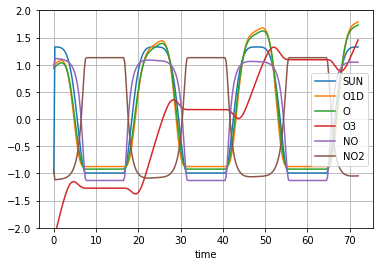

In [4]:
df.plot(y=['SUN', 'O1D', 'O', 'O3', 'NO', 'NO2'], #df.columns.drop('time'),
        ylim=[-2, 2], grid=True)

In [5]:
X = df.values
X.shape

(289, 6)

In [6]:
Y = df.drop('SUN', axis=1).values
Y.shape

(289, 5)

In [7]:
network = models.Sequential()
network.add(layers.Dense(10, activation='relu', input_shape=(6,)))
network.add(layers.BatchNormalization())
network.add(layers.Dense(10, activation='relu'))
network.add(layers.BatchNormalization())
network.add(layers.Dense(5, activation=None))


Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [8]:
network.compile(optimizer=keras.optimizers.Adam(lr=0.01), 
                loss='mse')
network.fit(X, Y, epochs=3, steps_per_epoch=1000, verbose=1)

Epoch 1/3
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0153
Epoch 2/3
1000/1000 [==============================] - 2s 2ms/step - loss: 6.5498e-05
Epoch 3/3
1000/1000 [==============================] - 2s 2ms/step - loss: 4.1454e-05


In [9]:
y_pred = network.predict(X)
r2_score(y_pred, Y)

0.99982024685375293

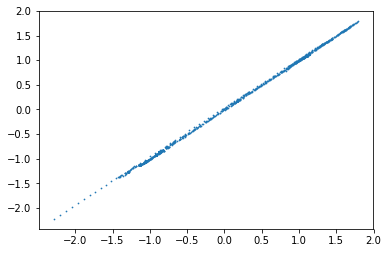

In [10]:
plt.scatter(y_pred.ravel(), Y.ravel(), s=0.5)

# Predict history

In [11]:
sun = df['SUN'].values
sun.shape

(289,)

In [12]:
pred_history = []
for t in range(288):
    x_temp = X[t].reshape(1,-1) # column vector
    y_temp = network.predict(x_temp)
    
    pred_history.append(y_temp.ravel().copy())
    
    # prepare for next step
    x_temp = np.c_[sun[t+1], y_temp]
    
pred_history = np.array(pred_history)

In [13]:
pred_history.shape

(288, 5)

In [14]:
df_pred = pd.DataFrame(pred_history, index=df.index[1:], 
                       columns=['O1D', 'O', 'O3', 'NO', 'NO2'])
df_pred.head()

,O1D,O,O3,NO,NO2
time,,,,,
0.25,1.003358,0.932029,-2.286694,0.962133,-0.940764
0.50,1.011077,0.959768,-2.205052,1.129179,-1.112230
0.75,1.028516,0.976943,-2.123299,1.127178,-1.110607
1.00,1.045139,0.993483,-2.042274,1.125299,-1.108915
1.25,1.060275,1.008744,-1.962129,1.123273,-1.107078


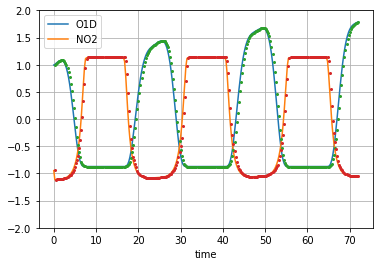

In [15]:
specs = ['O1D', 'NO2'] # ['O1D', 'O', 'O3', 'NO', 'NO2']

ax = df.plot(y=specs, ylim=[-2, 2], grid=True)

df_pred.plot(y=specs, ylim=[-2, 2], grid=True,
             marker='o', markersize=2.0, linewidth=0.0, ax=ax, legend=False)

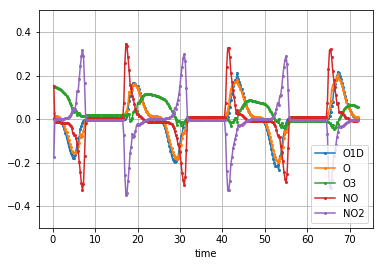

In [16]:
(df.iloc[1:] - df_pred).plot(y=['O1D', 'O', 'O3', 'NO', 'NO2'],
                             ylim=[-0.5, 0.5], grid=True,
                             marker='o', markersize=2.0,)

In [26]:
r2_score(df['NO2'].iloc[1:], df_pred['NO2'])

0.99703308301963789

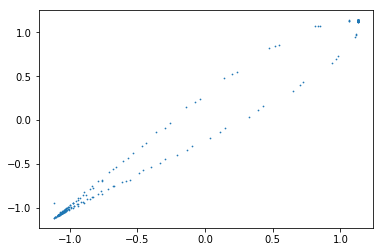

In [28]:
plt.scatter(df['NO2'].iloc[1:], df_pred['NO2'], s=0.5)